# HANGU_Data for simulation

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris  # used for cluster test
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import pickle
import time
from datetime import datetime
from chinese_calendar import is_workday
import multiprocessing
from sklearn.cluster import *
# It is used to divide samples and generate classification rules in the form of decision tree
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus
from IPython.display import Image, display
import copy
Tree_Flag=True # use decision tree or normal cutoff points
Seed = 42  # random seed
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
kk="Kmedians" # or kk="Kmeans" 
#kk="Kmeans"

##  Data reading

In [2]:
# read training data set（based on duration2,used for clustering to obtain classification rules）
df_0 = pd.read_csv("../Generated Data/train_data1224_0730.csv")
print(df_0.shape)
df_0.head()

(3319, 16)


,ID,Session,Month,DayOfWeek,WorkingDay,AM_PM,Visit.No,Gender,M.Cancer,S.Cancer,StartTime,PayTime,Address,ServTime,if_return2,duration_history
0,HAA052B7CD,1,January,Wednesday,True,morning,7,F,True,False,8:31:40,8:44:28,Out of city,691,True,744.000000
1,HA18BDDC46,1,January,Wednesday,True,morning,6,F,False,False,8:43:11,9:07:31,In the city,614,True,780.984442
2,HFC7DD5A0B,1,January,Wednesday,True,morning,2,F,False,False,8:53:25,9:08:38,NaN,559,True,541.000000
3,HE10BEEB38,1,January,Wednesday,True,morning,2,M,False,False,9:02:44,9:15:13,Out of city,749,True,580.250000
4,HBF11B62B6,1,January,Wednesday,True,morning,10,F,False,False,9:26:19,10:01:57,Out of city,450,True,537.833333


In [3]:
# Remove redundant (currently unwanted) variables
df = df_0.copy()
df.drop(columns = ['Session','Address','if_return2','duration_history','StartTime','PayTime'],inplace = True)

print(df.describe())
df.head()

          Visit.No     ServTime
count  3319.000000  3319.000000
mean      7.172642   805.088882
std      14.836481   362.153664
min       1.000000   181.000000
25%       1.000000   549.000000
50%       2.000000   731.000000
75%       6.000000   976.500000
max     141.000000  3286.000000


,ID,Month,DayOfWeek,WorkingDay,AM_PM,Visit.No,Gender,M.Cancer,S.Cancer,ServTime
0,HAA052B7CD,January,Wednesday,True,morning,7,F,True,False,691
1,HA18BDDC46,January,Wednesday,True,morning,6,F,False,False,614
2,HFC7DD5A0B,January,Wednesday,True,morning,2,F,False,False,559
3,HE10BEEB38,January,Wednesday,True,morning,2,M,False,False,749
4,HBF11B62B6,January,Wednesday,True,morning,10,F,False,False,450


In [4]:
# View the data overview and missing values
total_nan_values = df.isnull().sum().sum()
print ("The number of missing values is:",total_nan_values)
df.info()

The number of missing values is: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3319 entries, 0 to 3318
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          3319 non-null   object
 1   Month       3319 non-null   object
 2   DayOfWeek   3319 non-null   object
 3   WorkingDay  3319 non-null   bool  
 4   AM_PM       3319 non-null   object
 5   Visit.No    3319 non-null   int64 
 6   Gender      3319 non-null   object
 7   M.Cancer    3319 non-null   bool  
 8   S.Cancer    3319 non-null   bool  
 9   ServTime    3319 non-null   int64 
dtypes: bool(3), int64(2), object(5)
memory usage: 191.4+ KB


## Cluster


### Clusrer setting

In [5]:
XX =[np.nan for i in range(5)] # XX is the list of data with category labels after clustering for different K values.
CutPoints_List = [np.nan]*5 # Cut_Points is the list of cut points after clustering for different K values.
Label_list = ['#Cluster=2','#Cluster=3','#Cluster=4','#Cluster=5'] # The number of possible clusters involved, for subsequent annotation
X_init = df.iloc[:,1:]# Delete the first column ID which has little impact on clustering

# Normalizing numerical data
X_init_temp = X_init[X_init.describe().columns]# Numerical data
t = preprocessing.StandardScaler().fit(X_init_temp)
X_init_num = pd.DataFrame(t.transform(X_init_temp))
X_init_num.columns = X_init.describe().columns

# LabelEncode for categorical data
X_init_cate = X_init[["Month","DayOfWeek","WorkingDay","AM_PM","Gender","M.Cancer","S.Cancer"]]# Extract categorical data
le = preprocessing.LabelEncoder()
X_init_cate = X_init_cate.apply(le.fit_transform)

# Document the mapping relationship of label_encoding
def pkl_save(filename, file):
    output = open(filename, 'wb')
    pickle.dump(file, output)
    output.close()
 
pkl_save('HANGU_clinic_new_labelencoding.pkl', le)

# Column-wise stitching of processed numeric and categorical data
X_init_processed = pd.concat([X_init_num,X_init_cate],axis=1)
X_init_processed.describe()

,Visit.No,ServTime,Month,DayOfWeek,WorkingDay,AM_PM,Gender,M.Cancer,S.Cancer
count,3.319000e+03,3.319000e+03,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000,3319.000000
mean,1.730145e-16,-1.016896e-16,5.517324,1.813498,0.456764,0.514914,0.403435,0.084363,0.006930
std,1.000151e+00,1.000151e+00,3.337855,0.984747,0.498202,0.499853,0.490660,0.277973,0.082969
min,-4.161076e-01,-1.723531e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.161076e-01,-7.072342e-01,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.486960e-01,-2.046094e-01,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,-7.904968e-02,4.733818e-01,8.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,9.021514e+00,6.851470e+00,11.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# sum of absolute error
def Fun_Absolute_Error(df,Medians):  #Used to calculate the sum of absolute error
    AE = []
    for i in range(0,df.shape[0]):
        distance = [abs(df[i,:] - x) for x in Medians]
        Absolute_Error =min(distance)
        AE.append(Absolute_Error)
    
    return sum(AE)

In [7]:
# Used for KMedians
def TrainKMedians(df, model_name=None, start_k=1, end_k=8, random_state=Seed):
    print('training KMedians cluster')
    K = []
    SSE = []
    SAE = []
    Silhouette = []
    models = [] #Save the model each time
    
    for i in range(start_k, end_k):
        start = time.perf_counter ()
        initial_centers = df[0:i,:]
        kmedians_model = kmedians(data=df,initial_medians=initial_centers,random_state=random_state)
        kmedians_model.process()
        kmed_pre = kmedians_model.get_clusters() # Clustering results
        
        kmed_pre_label = np.arange(len(df))
        for ii,li in enumerate(kmed_pre):
            kmed_pre_label[li] = ii
        
        #By setting "self.__metric = kwargs.get('metric', distance_metric(type_metric.EUCLIDEAN_SQUARE))" in kmedians.py
        #If EUCLIDEAN_SQUARE distance is used .get_total_wce() output SSE
        #If MANHATTAN distance is used .get_total_wce() output SAE
        kmedians_model.labels_= kmed_pre_label
        SSE_score = kmedians_model.get_total_wce()
        SSE.append(SSE_score)  # Save the wce value for each k value
        
        # Verification can also be done by manual calculation 
        Medians = kmedians_model.get_medians()
        SAE_score = Fun_Absolute_Error(df,Medians)
        SAE.append(SAE_score)  # Save the sae value for each k value
        
        K.append(i)
        if i >= 2:
            sc_score = silhouette_score(df,kmed_pre_label,metric='manhattan')
            Silhouette.append(sc_score) # Save the average profile coefficient value for each k value
            ch_score = calinski_harabasz_score(df,kmedians_model.labels_)
            db_score = davies_bouldin_score(df,kmedians_model.labels_)

        print('{}-KMedians SSE loss = {}'.format(i, SSE_score))
        print('{}-KMedians SAE loss = {}'.format(i, SAE_score))
        if i >= 2:
            print('{}-KMedians silhouette_score = {}'.format(i, sc_score))
            print('{}-KMedians calinski_harabasz_score = {}'.format(i, ch_score))
            print('{}-KMedians davies_bouldin_score = {}'.format(i, db_score))
         
        models.append(kmedians_model) #Save the model corresponding to each k value
        end = time.perf_counter ()
        print('Running time: %s Seconds'%(end-start))
        print("--------------cutting line---------------")
 
    return(K,SAE,models,Silhouette) #return SAE or SSE

In [8]:
# Used for KPrototypes
def TrainCluster(df,cate, model_name=None, start_k=2, end_k=8,random_state=Seed):
    print('training cluster')
    K = []
    SSE = []
    Silhouette = []
    models = [] #Save the model each time
    for i in range(start_k, end_k):
        start = time.perf_counter ()
        kproto_model = KPrototypes(n_clusters=i,n_jobs=multiprocessing.cpu_count(),random_state=random_state)
        kproto_model.fit(df,categorical=cate)
        SSE.append(kproto_model.cost_)  # Save the SSE value for each k value
        K.append(i)
        sc_score = silhouette_score(df, kproto_model.labels_\
                            ,sample_size=10000, metric='euclidean')
        Silhouette.append(sc_score) # Save the average silhouette coefficient value for each k value
        
        print('{}-prototypes SSE loss = {}'.format(i, kproto_model.cost_))
        models.append(kproto_model) #Save the model corresponding to each k value
        end = time.perf_counter ()
        print('Running time: %s Seconds'%(end-start))
 
    return(K,SSE,models,Silhouette)

In [9]:
# Define functions to draw elbow diagrams
def SAE_plot(K,SAE):
    
    #plt.figure()
    plt.figure(figsize=[35, 25])
    plt.plot(K,SAE,'bo-',linewidth=10,markersize=20)
    #plt.plot(K[1:2],SAE[1:2],'bo-')
    #plt.rcParams['figure.figsize'] = [40,20]
    plt.xlabel('Number of cluster centers',fontsize=120)
    plt.ylabel('Sum of Absolute Errors',fontsize=120) # SAE or Sum of Absolute Error
    plt.xticks(fontsize=100)
    plt.yticks(fontsize=100)
    #plt.title('Use the elbow rule to determine the best k value') 
    plt.savefig("./figures/Elbow Diagram_0902.pdf",dpi=300,format="pdf")
    plt.show()

In [10]:
# Define the function to plot the Silhouette Coefficient
def silhouette_plot(K,Silhouette):
    
    #plt.figure()
    plt.figure(figsize=[35, 25])
    plt.plot(K[1:], Silhouette, 'bo-', linewidth=10,markersize=20)
    #plt.rcParams['figure.figsize'] = [40,20]
    plt.xlabel('Number of cluster centers',fontsize=120)
    plt.ylabel('Silhouette Coefficient',fontsize=120)  #Sample average contour coefficient
    plt.xticks(fontsize=100)
    plt.yticks(np.arange(0.49, 0.58, 0.01),fontsize=100)
    plt.savefig("./figures/Silhouette Coefficient Diagram_0902.pdf",dpi=300,format="pdf")
    plt.show()

In [11]:
def SAE_SC_plot(K, SAE, Silhouette):
    plt.figure(figsize=(50, 20))
    
    plt.subplot(1, 2, 1)  # create the first subplot
    plt.plot(K, SAE, 'bo-',linewidth=5,markersize=15)
    plt.xlabel('Number of cluster centers', fontsize=80)
    plt.ylabel('Sum of Absolute Errors', fontsize=80)
    plt.xticks(fontsize=80)
    plt.yticks(fontsize=80)
    #plt.title('Use the elbow rule to determine the best k value')
    
    plt.subplot(1, 2, 2)  # create the second subplot
    plt.plot(K[1:], Silhouette, 'bx-', linewidth=5,markersize=15)
    plt.xlabel('Number of cluster centers', fontsize=80)
    plt.ylabel('Silhouette Coefficient', fontsize=80)
    plt.xticks(fontsize=80)
    plt.yticks(fontsize=80)
    
    plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing between subgraphs
    
    plt.savefig("./figures/Combined_plot.pdf", dpi=300, format="pdf")
    plt.show()

In [12]:
#Define the function Cluster_fun for multiple cluster number k values and plot the scatter plot
def KmedCluster_fun(X,K,k,models,X_0):
    '''
    X is the processed data to be clustered
    K is the list of trained clustering models
    k is the number of clusters to be clustered
    models is the list of trained clustering models
    X_0 is the raw unnormalized data
    '''
   
    best_kmeans=models[K.index(k)]# After determining the best k, the corresponding best_kmeans clustering model can be obtained
    kmed_pre=best_kmeans.get_clusters()
    kmed_pre_label = np.arange(len(X))
    for ii,li in enumerate(kmed_pre):
        kmed_pre_label[li] = ii
    
    # Extracting the center of each cluster
    centers=best_kmeans.get_medians() # Center of k clusters
    #center = np.array(best_kmeans.get_medians())
    center=pd.DataFrame(centers) # Center of k clusters（DataFrame Format）
    center.columns=['ServTime'] #Adding column labels to a DataFrame with k cluster centers

    # Restore each cluster center to get the original value corresponding to the one before normalization
    for col in ['ServTime']:
        col_new=col+"_clu"
        mean=X_0[col].mean()
        std=X_0[col].std()
        center[col_new]=center[col]*std+mean
        
    X_0["Cluster"]=kmed_pre_label
    #print("SAE value:",best_kmeans.get_total_wce())
    #print("Number of iterations:",best_kmeans.n_iter_)
    center=center.sort_values('ServTime_clu').reset_index(drop=True)
    print(center)# Center of k clusters (format before normalization)
    
    Cut_Points=[np.nan]*(k-1)
    if k==2:
        Cut_Points[0]=sum(center["ServTime_clu"])/2
    if k==3:
        Cut_Points[0]=sum(center["ServTime_clu"][0:2])/2
        Cut_Points[1]=sum(center["ServTime_clu"][1:3])/2
            
    # Plotting scatter plots
    markers_List = ["^","s","o","D","+","d","h"]
    print(f'The scatter plot when the number of clusters clustered is {k} is:')
    sns.lmplot(x="Visit.No",y ="ServTime", hue="Cluster",markers=markers_List[:len(centers)],data=X_0,height=8,aspect=1.5) # Plot scatter plot of raw data
    #plt.scatter(center["Visit.No_clu"],center["ServTime_clu"],marker="*",color="red") # Mapping cluster centers
    plt.xticks(fontsize=10,rotation= -45)
    plt.yticks(fontsize=10,rotation= -45)
    plt.xlabel("Visit.No")
    plt.ylabel("ServTime")
    plt.show()
    return (X_0,Cut_Points)

In [13]:
# Used for KPrototypes
# Define the function Cluster_fun for multiple cluster number k values and plot the scatter plot
def Cluster_fun(X,K,k,models,X_0):
    '''
    X is the processed data to be clustered
    K is the list of trained clustering models
    k is the number of clusters to be clustered
    models is the list of trained clustering models
    X_0 is the raw unnormalized data
    '''
    best_kproto=models[K.index(k)]# After determining the best k, the corresponding best_kproto clustering model can be obtained
    clusters=best_kproto.labels_ # class labels
    
    # Extracting the center of each cluster
    centers=best_kproto.cluster_centroids_ # k centers of clusters
    center=pd.DataFrame(centers) # k centers of clusters（DataFrame Format）
    center.columns=X.columns #Adding column labels to a DataFrame with k cluster centers

    # Restore each cluster center to get the original value corresponding to the one before normalization
    for col in X_0.describe().columns:
        col_new=col+"_clu"
        mean=X_0[col].mean()
        std=X_0[col].std()
        center[col_new]=center[col]*std+mean
        
    X_0["Cluster"]=clusters
    print(center)# k centers of clusters（Format before standardization）
    print("SSE value:",best_kproto.cost_)
    print("Number of iterations:",best_kproto.n_iter_)
    
    # Plotting scatter plots
    markers_List = ["^","s","o","D","+","d","h"]
    print(f'The scatter plot when the number of clusters clustered is {k} is:')
    sns.lmplot(x="Visit.No",y ="ServTime", hue="Cluster",markers=markers_List[:len(centers)],data=X_0,height=8,aspect=1.5) # Plot scatter plot of raw data
    plt.scatter(center["Visit.No_clu"],center["ServTime_clu"],marker="*",color="red") # Mapping cluster centers
    plt.xticks(fontsize=10,rotation= -45)
    plt.yticks(fontsize=10,rotation= -45)
    plt.xlabel("Visit.No")
    plt.ylabel("ServTime")
    plt.show()
    return X_0

In [14]:
# Define a batch plot of the frequency of each type of element in the cluster as a bar chart
def Plot_Cluster(XX,ii,Label_):
    plt.figure() 
    plt.rcParams['figure.figsize'] = (8.0, 8.0)
    List=list(XX[ii]["Cluster"])
    x_value0=list(set(XX[ii]["Cluster"]))
    x_value=list(map(str,list(set(XX[ii]["Cluster"]))))
    y_value=[]

    for i in x_value0:
        y_value.append(XX[ii].Cluster.value_counts()[i]) #XX[ii].Cluster.value_counts() Count the frequency of each category

    plt.bar(x_value,y_value,facecolor = 'yellowgreen', edgecolor = 'white',label=Label_)
    plt.xticks(fontsize=10)
    plt.grid(alpha=0.5,linestyle='-.')
    plt.xlabel("Type")
    plt.ylabel("Count")
    plt.legend()
    for j in range(len(x_value)):
        plt.text(j,y_value[j]+5,"%.0f" %y_value[j],ha='center',va='bottom',fontsize=10) 
    plt.show()

####  Streamlined to ServTime one feature

##### KMedian

In [15]:
if kk=="Kmedians":
    df2array = X_init_processed.values
    X_init_simp_5 = df2array[:,1].copy().reshape(-1, 1)# cluster on only ServTime
    #X_init_simp_5 = df2array[:,2].copy().reshape(-1, 1)# cluster on only predict ServTime:pred_xgb

training KMedians cluster
1-KMedians SSE loss = 3457.949964885133
1-KMedians SAE loss = [2422.69311002]
Running time: 0.04827949999999959 Seconds
--------------cutting line---------------
2-KMedians SSE loss = 1470.2581771442042
2-KMedians SAE loss = [1462.24057671]
2-KMedians silhouette_score = 0.5662910931220411
2-KMedians calinski_harabasz_score = 4674.014930083114
2-KMedians davies_bouldin_score = 0.6249329950027251
Running time: 0.2558373999999972 Seconds
--------------cutting line---------------
3-KMedians SSE loss = 933.1846773083505
3-KMedians SAE loss = [1065.49836129]
3-KMedians silhouette_score = 0.510350977244259
3-KMedians calinski_harabasz_score = 4723.304112716716
3-KMedians davies_bouldin_score = 0.5982497804462996
Running time: 0.16008229999999912 Seconds
--------------cutting line---------------
4-KMedians SSE loss = 671.4843214391476
4-KMedians SAE loss = [851.28904806]
4-KMedians silhouette_score = 0.49312265990700777
4-KMedians calinski_harabasz_score = 4869.856483

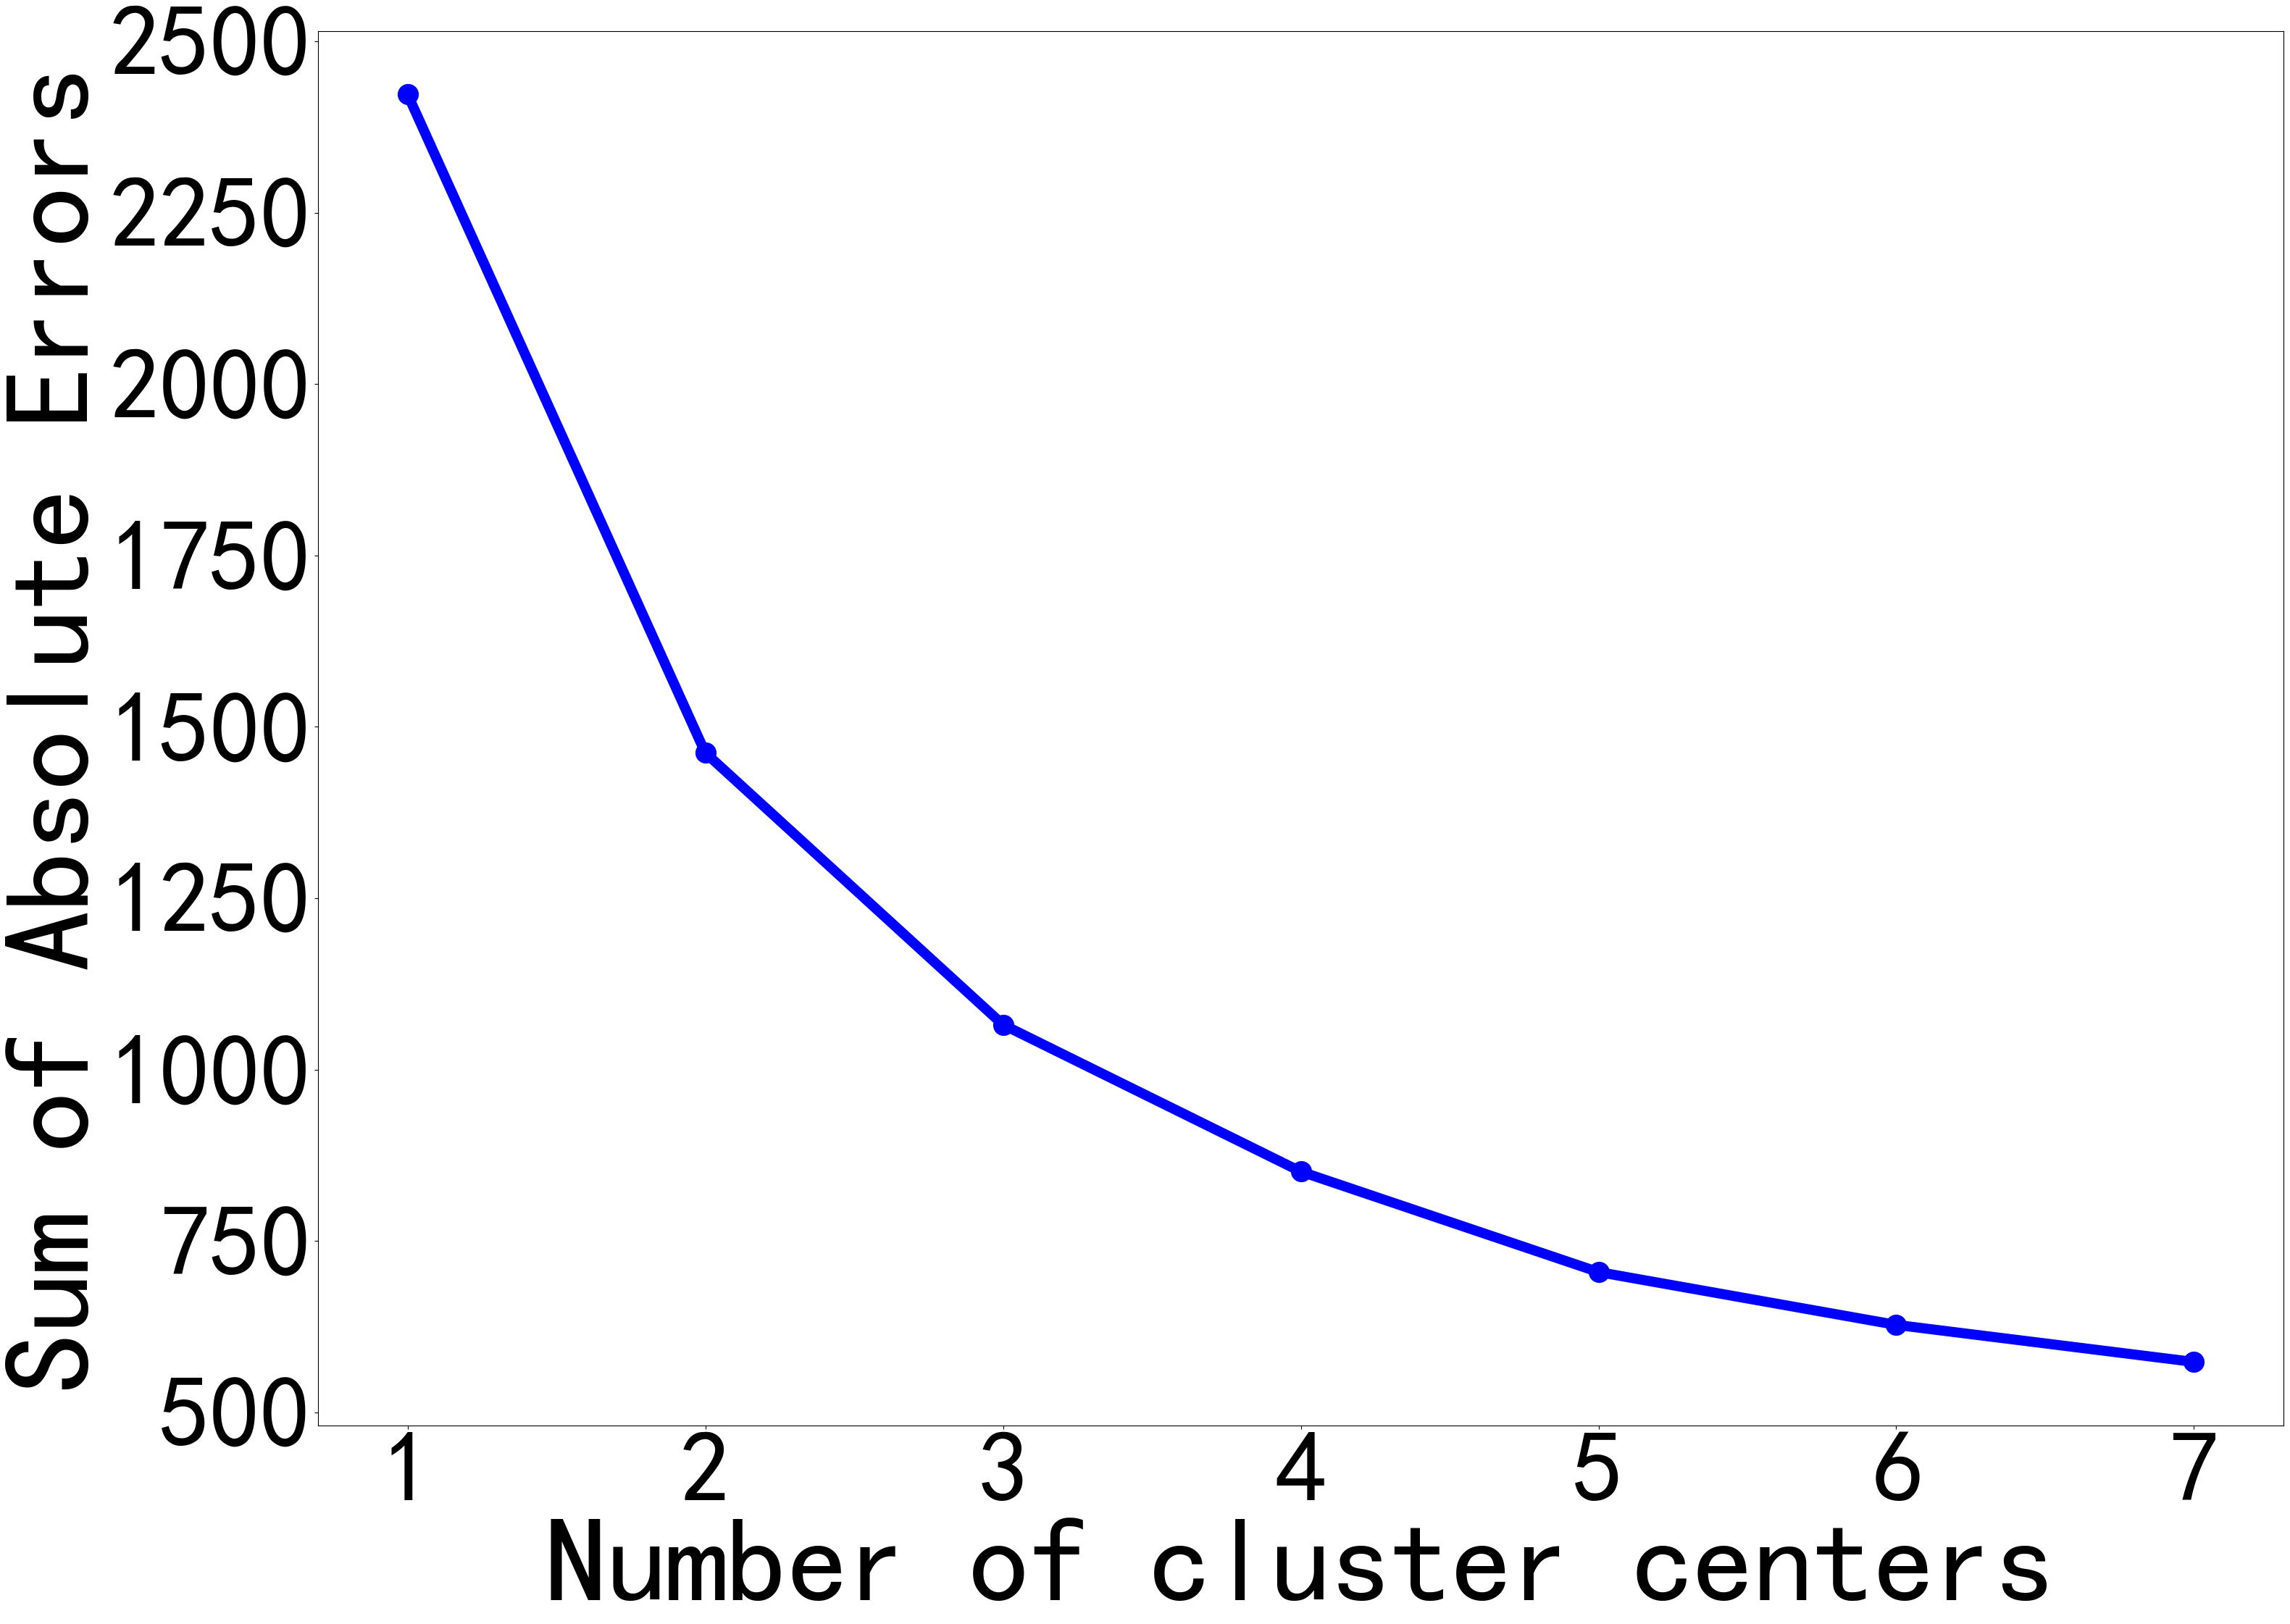

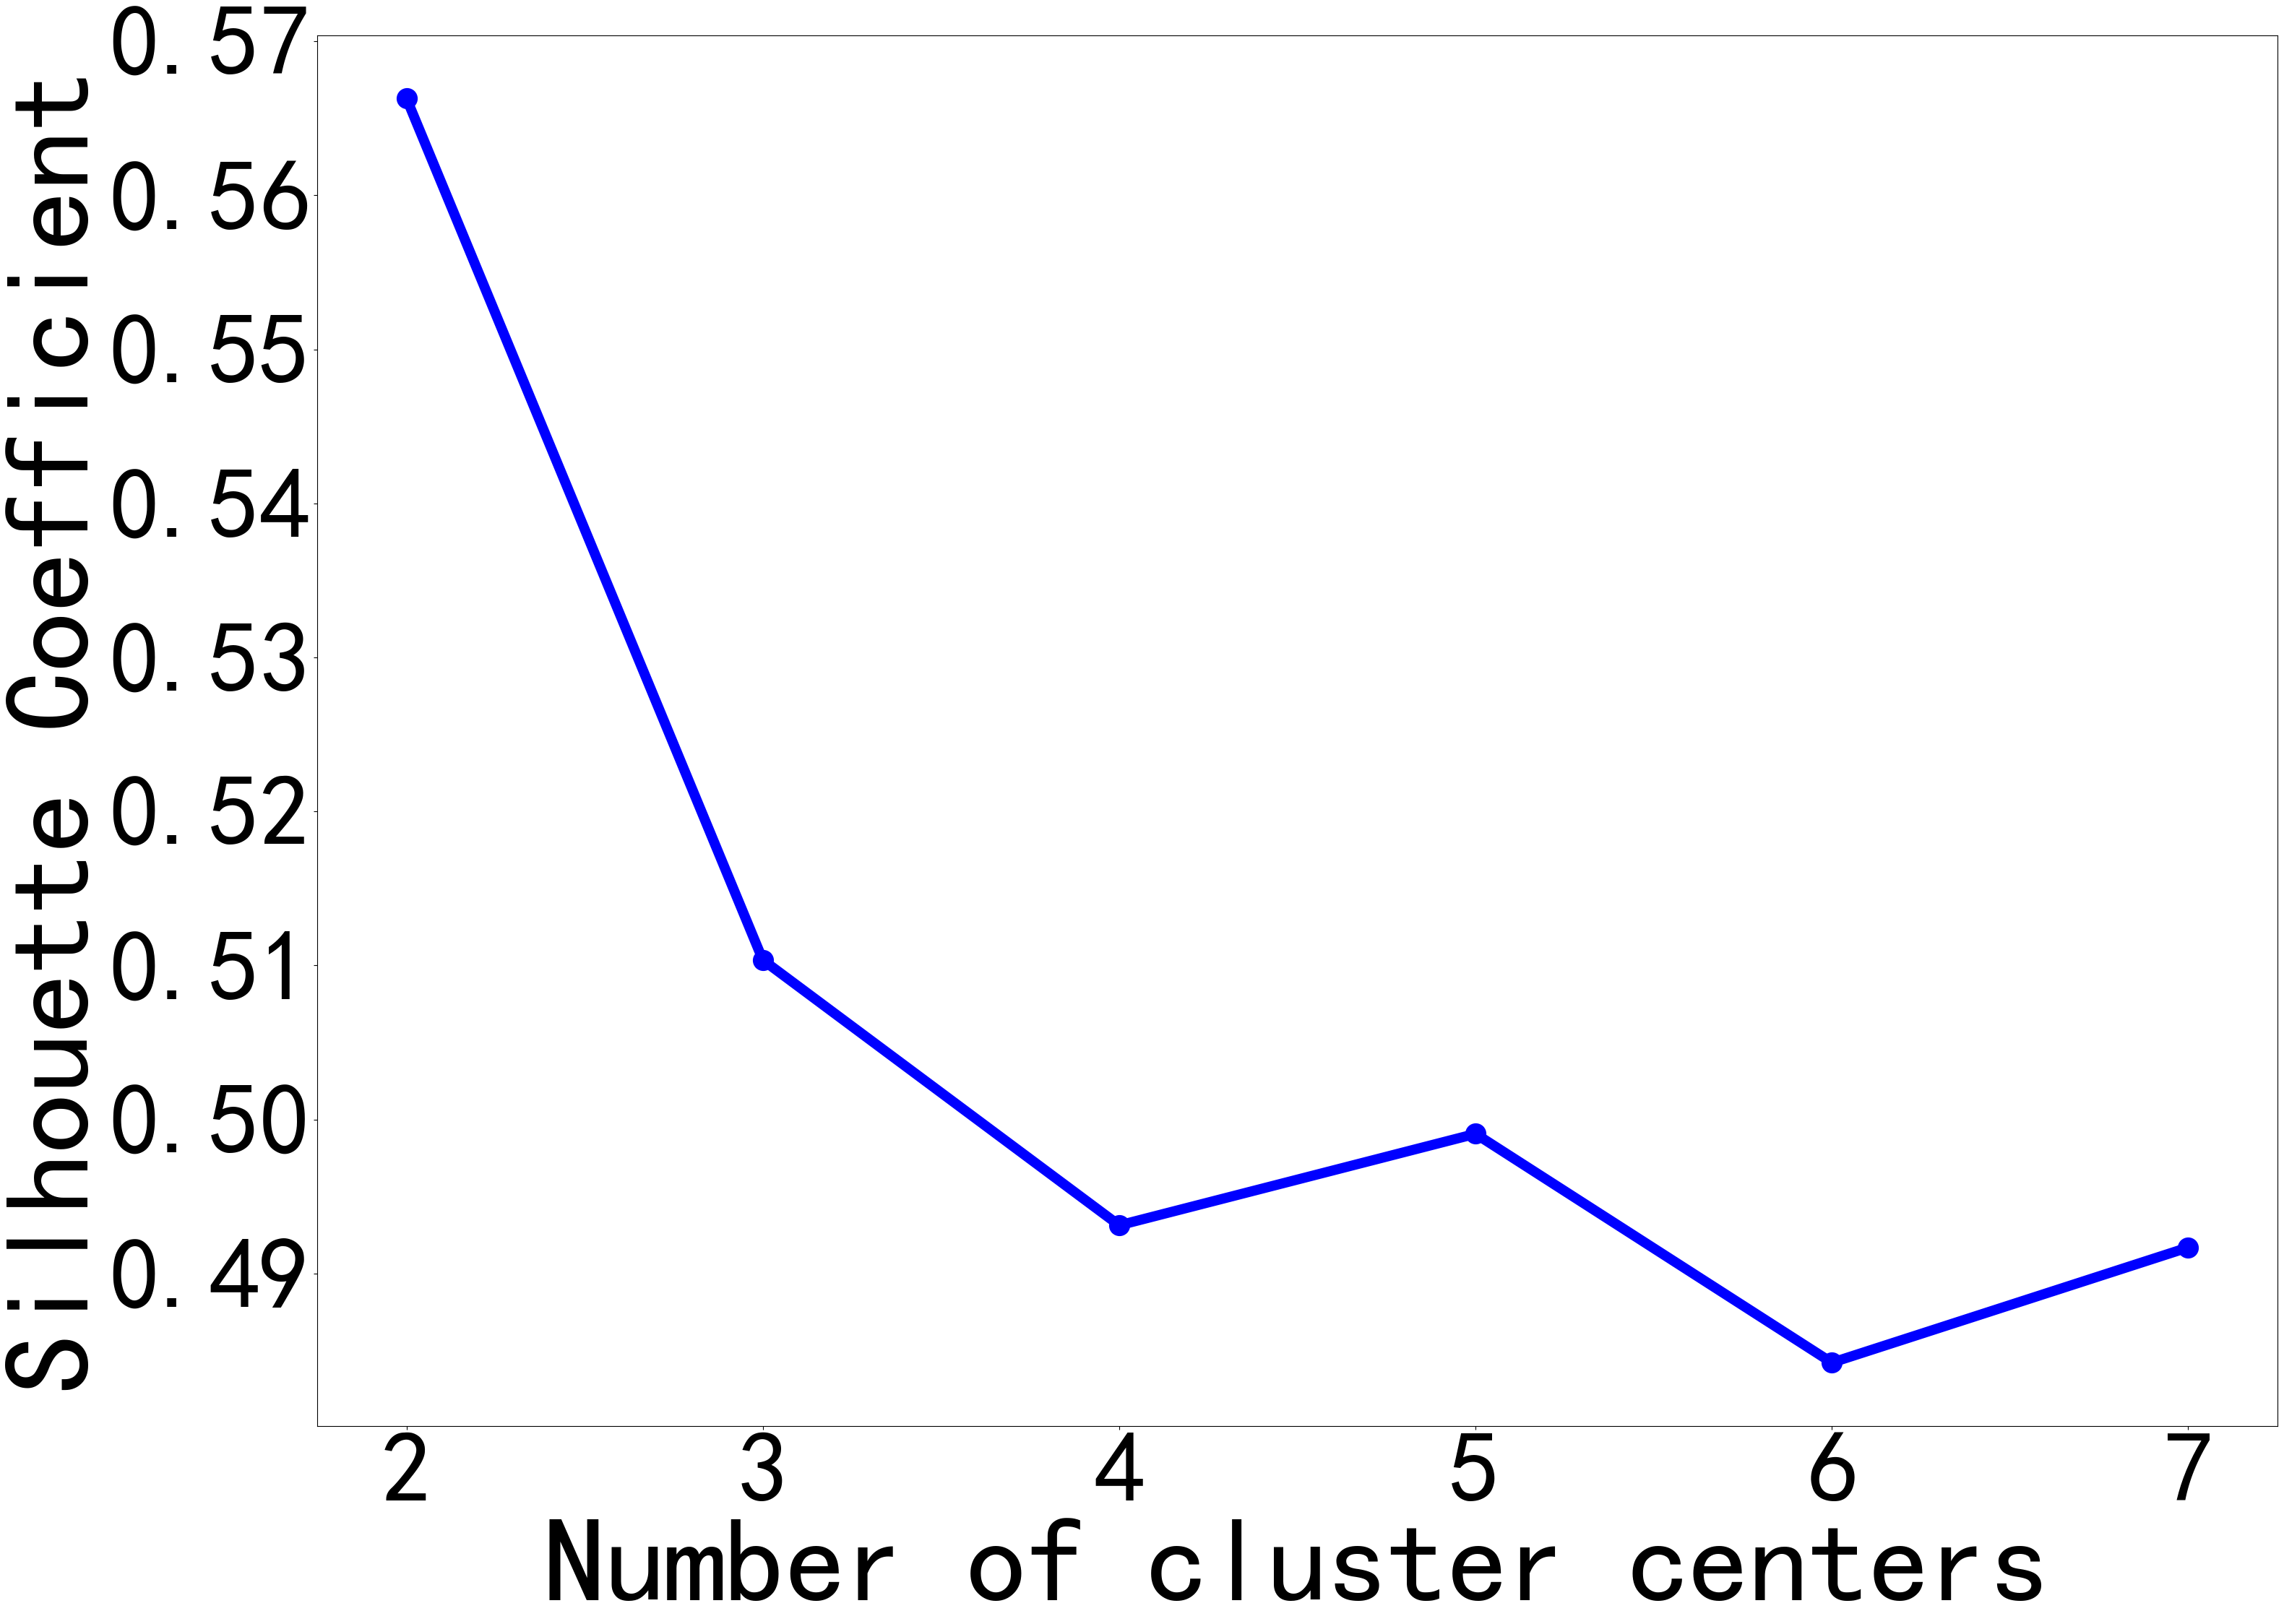

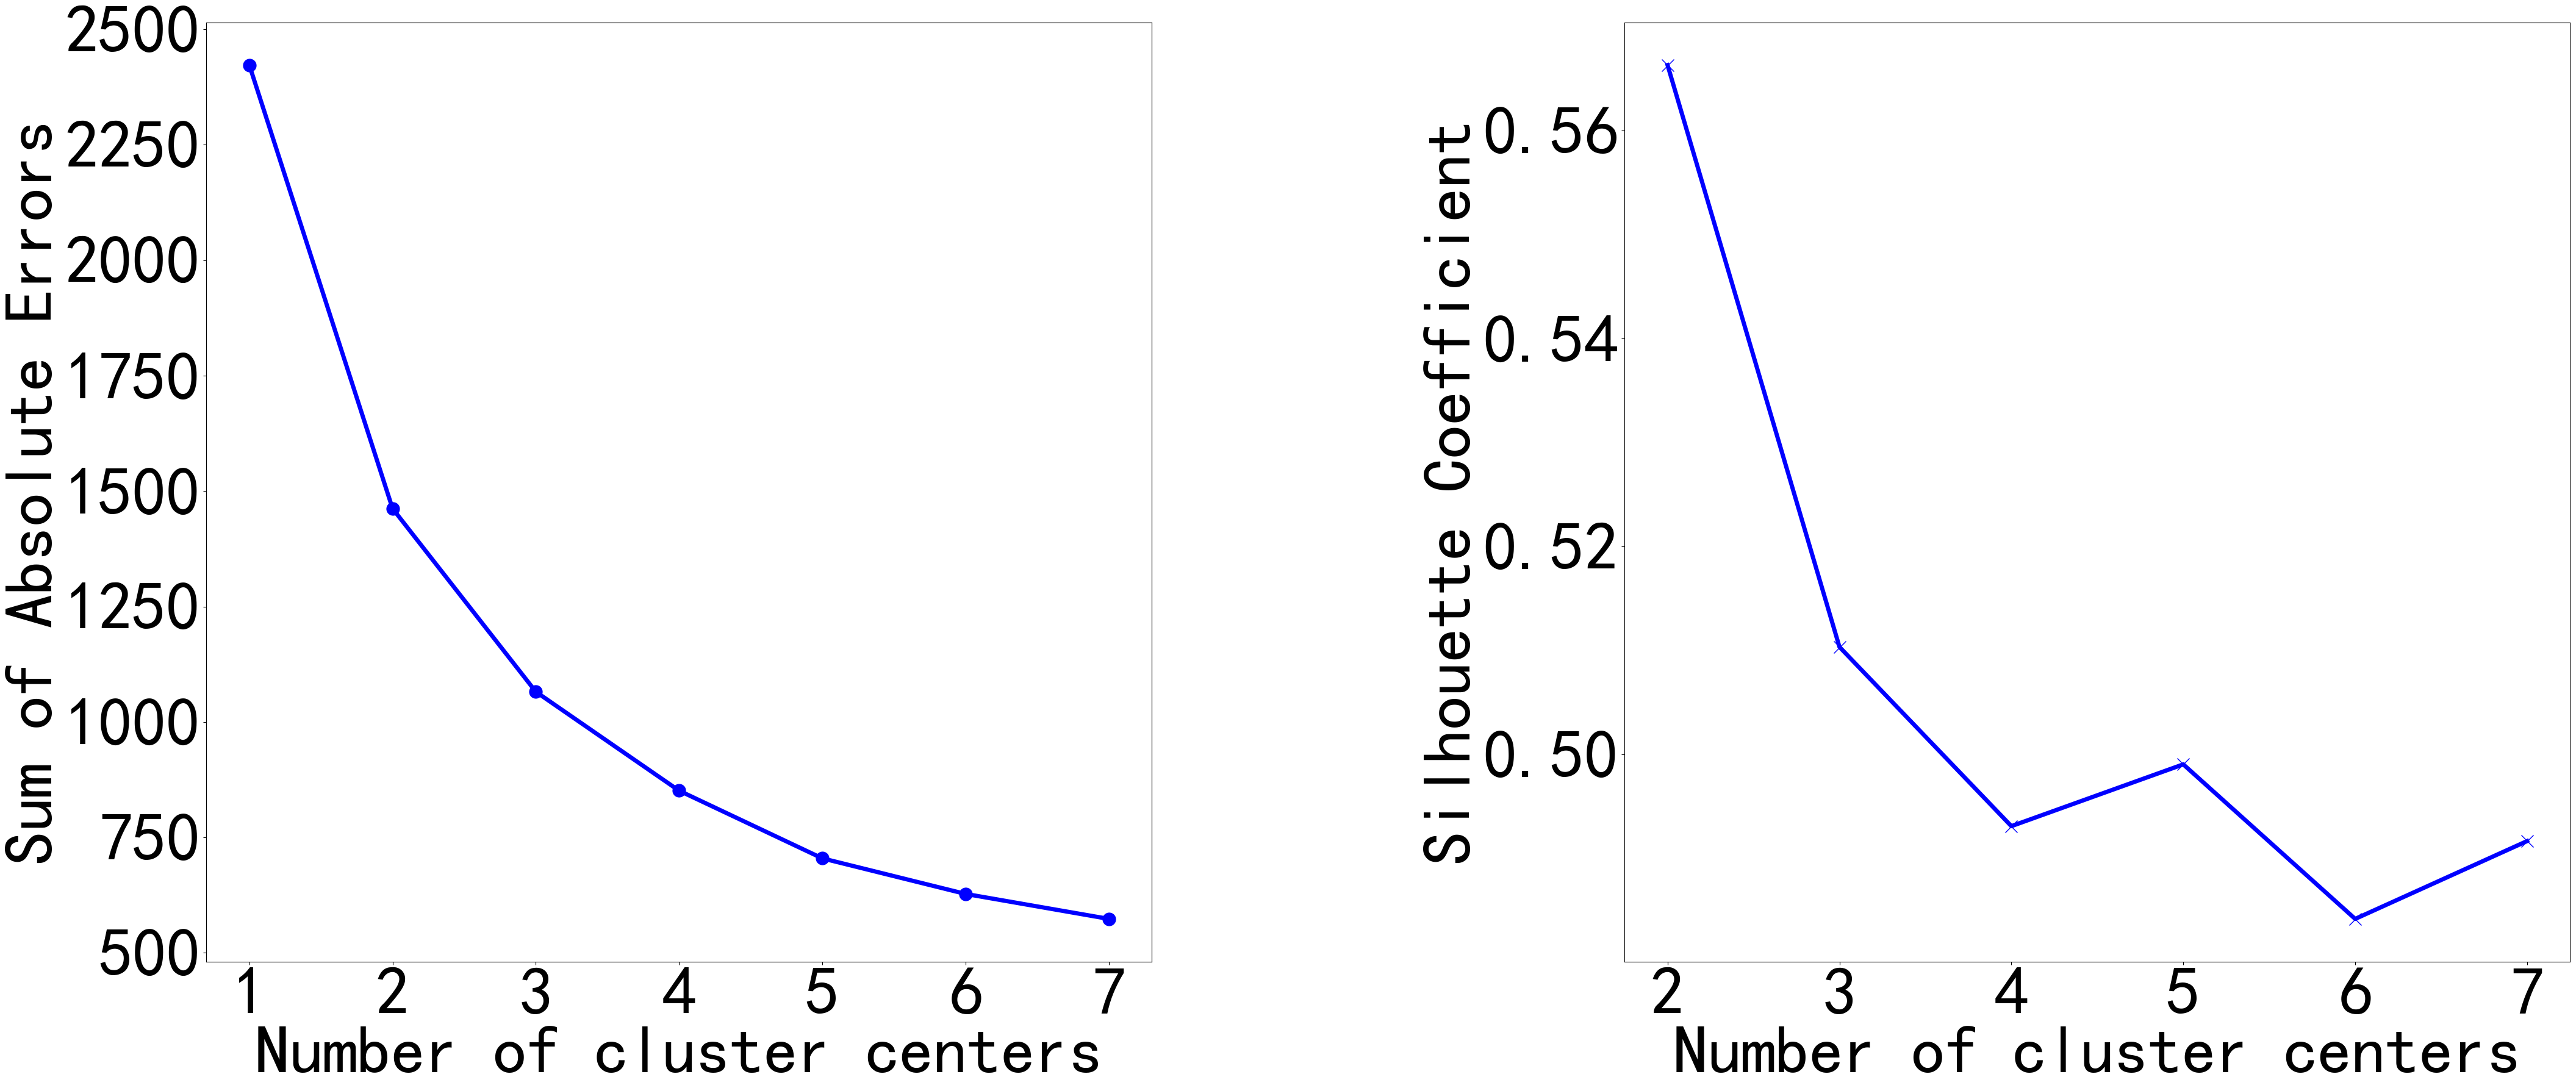

In [16]:
if kk=="Kmedians":
    # Model Training 5
    K_5,SAE_5,models_5,Silhouette_5 = TrainKMedians(X_init_simp_5)

    # Drawing the elbow figure
    SAE_plot(K_5,SAE_5)

    # Plotting silhouette coefficients figure
    silhouette_plot(K_5,Silhouette_5)

    SAE_SC_plot(K_5,SAE_5,Silhouette_5)

From the elbow diagram, it can be seen that k=2 or 3 is better, but in the average contour coefficient diagram, the contour coefficient at k=2 is greater than that at k=3. Comprehensive analysis of k=2.

In [17]:
CI=False #confidence interval

if CI==True:  
    # sample data

    X=X_init_simp_5 

    for k in [2,3]:

        # Calculating confidence intervals using the bootstrap method
        n_bootstraps = 1000
        silhouette_indices = []
        db_indices = []
        ch_indices = []
        for ii in range(n_bootstraps):
            while True:
                # random sampling
                indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
                sample = X[indices]

                # clustering
                initial_centers = sample[0:k,:]
                kmedians_model = kmedians(data=sample, initial_medians=initial_centers, random_state=42)
                kmedians_model.process()
                labels = kmedians_model.predict(sample)
                # Check whether the sample sampled contains more than one category
                unique_labels = np.unique(labels)
                if len(unique_labels) > 1:
                    break

            # calculating Silhouette and Davies-Bouldin
            sc_score = silhouette_score(sample, labels,metric='manhattan')
            db_index = davies_bouldin_score(sample, labels)
            silhouette_indices.append(sc_score)
            db_indices.append(db_index)
            # calculating Calinski_Harabasz
            ch_score = calinski_harabasz_score(sample, labels)
            ch_indices.append(ch_score)


        # calculating CI
        mean_db = np.mean(silhouette_indices)
        std_db = np.std(silhouette_indices)
        ci_lower = mean_db - 1.96 * std_db
        ci_upper = mean_db + 1.96 * std_db

        # output
        print("When k={}, Silhouette index: {}".format(k,mean_db))
        print("95% CI: [{:.3f}, {:.3f}]".format(ci_lower, ci_upper))    


        # calculating CI
        mean_db = np.mean(db_indices)
        std_db = np.std(db_indices)
        ci_lower = mean_db - 1.96 * std_db
        ci_upper = mean_db + 1.96 * std_db

        # output
        print("When k={}, Davies-Bouldin index: {}".format(k,mean_db))
        print("95% CI: [{:.3f}, {:.3f}]".format(ci_lower, ci_upper))

        # calculating CI
        mean_db = np.mean(ch_indices)
        std_db = np.std(ch_indices)
        ci_lower = mean_db - 1.96 * std_db
        ci_upper = mean_db + 1.96 * std_db

        # output
        print("When k={}, Calinski_Harabasz index: {}".format(k,mean_db))
        print("95% CI: [{:.3f}, {:.3f}]".format(ci_lower, ci_upper))


In [18]:
CII=False

if CII==True:
    
    X=X_init_simp_5 # sample data

    for k in [2,3]:

        # Calculating confidence intervals using the bootstrap method
        n_bootstraps = 1000
        SAE_indices = []
        for ii in range(n_bootstraps):
            while True:
                # random sampling
                indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
                sample = X[indices]

                # clustering
                initial_centers = sample[0:k,:]
                kmedians_model = kmedians(data=sample, initial_medians=initial_centers, random_state=42)
                kmedians_model.process()
                labels = kmedians_model.predict(sample)
                # Check whether the sample sampled contains more than one category
                unique_labels = np.unique(labels)
                if len(unique_labels) > 1:
                    break

            # calculating SAE
            Medians = kmedians_model.get_medians()
            SAE_score = Fun_Absolute_Error(sample,Medians)
            SAE_indices.append(SAE_score)

        # calculating CI
        mean_db = np.mean(SAE_indices)
        std_db = np.std(SAE_indices)
        ci_lower = mean_db - 1.96 * std_db
        ci_upper = mean_db + 1.96 * std_db

        # out put
        print("When k={}, SAE_score: {}".format(k,mean_db))
        print("95% CI: [{:.3f}, {:.3f}]".format(ci_lower, ci_upper))

The number of clusters for clustering is set to k= 2
   ServTime  ServTime_clu
0 -0.594006    589.967590
1  0.676365   1050.036904
The scatter plot when the number of clusters clustered is 2 is:


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


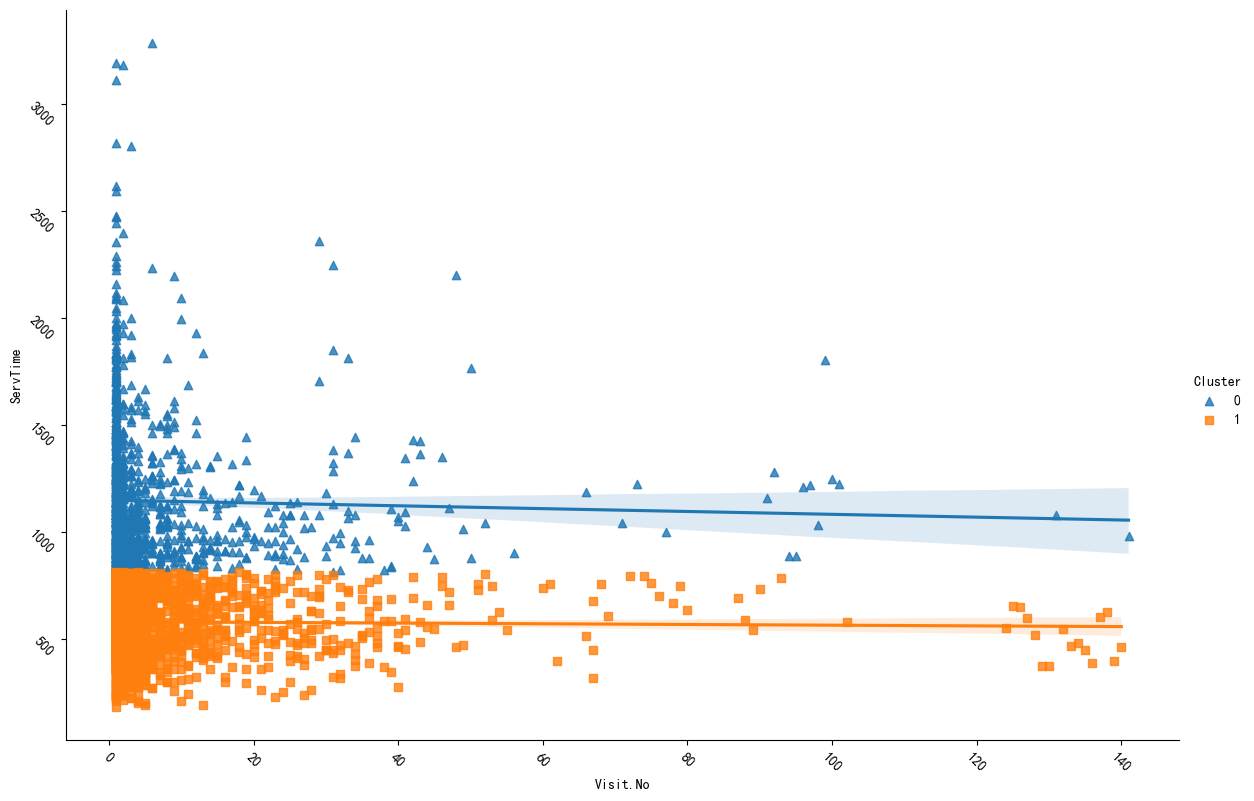

The corresponding sample bars after clustering are:


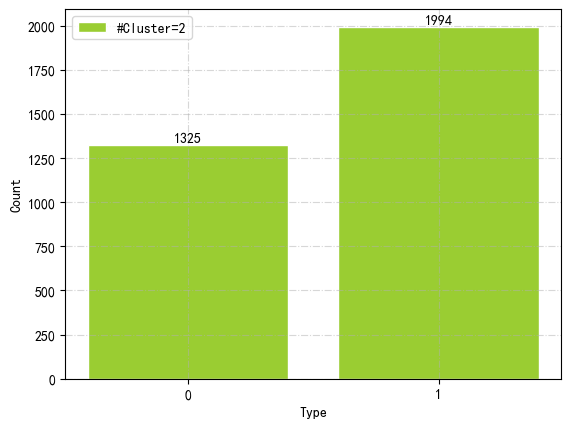

The number of clusters for clustering is set to k= 3
   ServTime  ServTime_clu
0 -0.842556    499.954029
1 -0.085857    773.995315
2  1.068523   1192.058300
The scatter plot when the number of clusters clustered is 3 is:


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


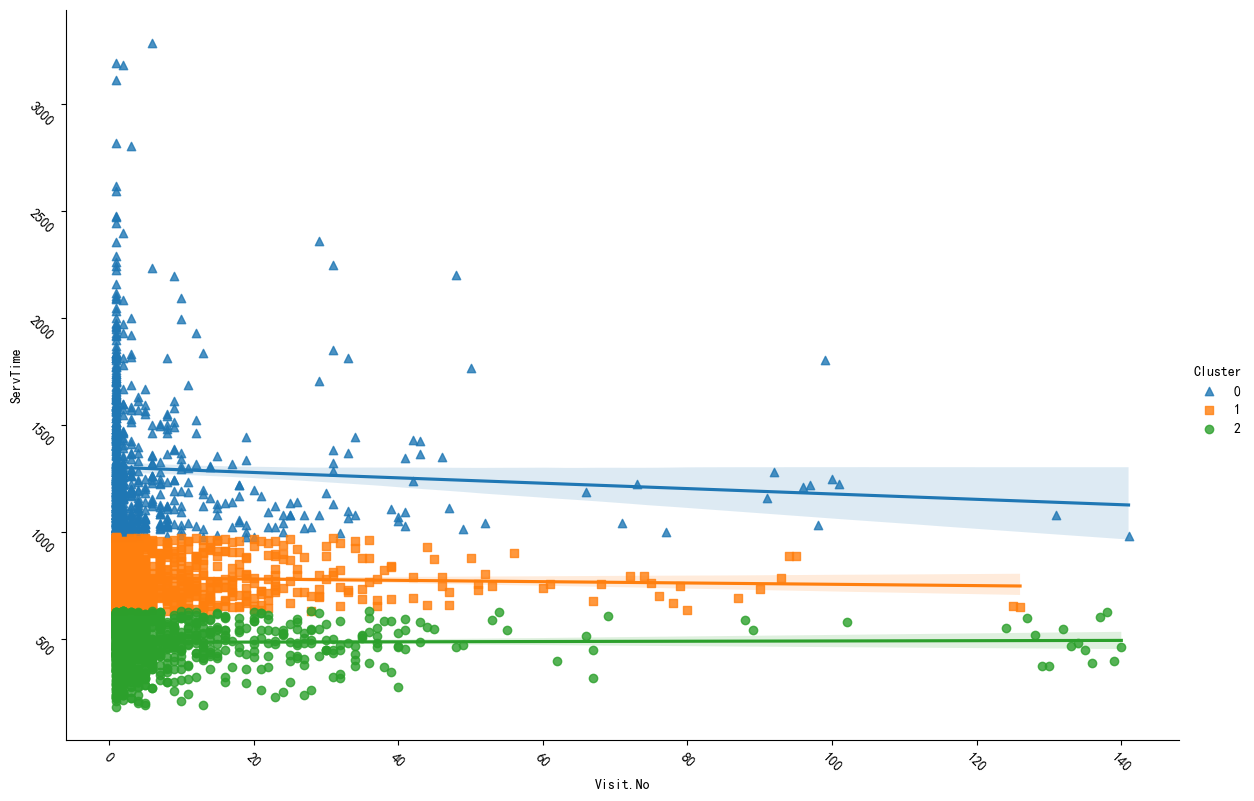

The corresponding sample bars after clustering are:


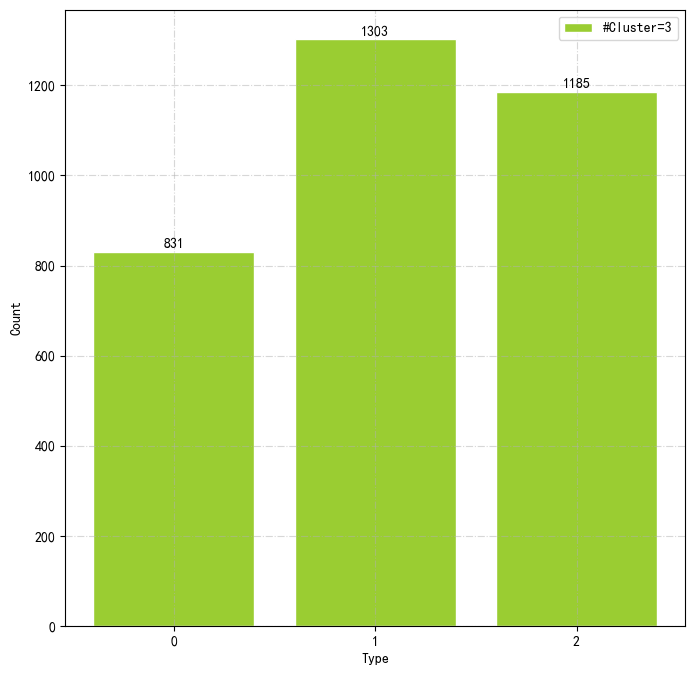

In [19]:
# Separate k-clustering of the cleaned data, k=3
if kk=="Kmedians":
    for k in [2,3]:
        print("The number of clusters for clustering is set to k=",k)
        X=X_init_simp_5.copy()
        X_0=X_init.copy()

        XX[k],CutPoints_List[k]=KmedCluster_fun(X,K_5,k,models_5,X_0)
         # Draw bar charts
        print("The corresponding sample bars after clustering are:")
        Plot_Cluster(XX,k,Label_list[k-2])

In [20]:
print(CutPoints_List)

[nan, nan, [820.0022468346102], [636.9746720585931, 983.0268079739042], nan]


### Showing the clustering effect

At present, comparing the above clustering models from both the elbow method and the average contour coefficient method, it is known that models_5 obtains the most satisfactory results, and the clustering results of models_5 are shown below.

In [21]:
# Define a function to see the classification and the average service time for each category
def ClusterMean(df_pro,ClassNameList,ServTime_flag='ServTime'):
    
    for c in ClassNameList:
        print(df_pro[c].value_counts().sort_index()) #View categories and the number of records they contain
        for m in sorted(set(df_pro[c])):
            mean=df_pro[df_pro[c]==m][ServTime_flag].mean()/60  #in minutes
            print(f'mean {ServTime_flag} of {m} is {mean} min') #View the average service time for each category
            percent=df_pro[df_pro[c]==m].shape[0]/df_pro.shape[0]
            num_to_16=16*percent
            print(f'percent of {m} is {percent}') #View the ratio of each category
            print(f'num_to_16 of {m} is {num_to_16}') #View the number of patients in each category corresponding to 16
            print("----------")
        print("----------")

In [22]:
# Define a function to view the classification and the median service time for each category
def ClusterMedian(df_pro,ClassNameList,ServTime_flag='ServTime'):
    
    for c in ClassNameList:
        Medians=[]
        print(df_pro[c].value_counts().sort_index()) #View categories and the number of records they contain
        for m in sorted(set(df_pro[c])):
            median=df_pro[df_pro[c]==m][ServTime_flag].median() #in seconds
            print(f'median {ServTime_flag} of {m} is {median} s') #View the median service time for each category
            Medians.append(median)
        print("The medians is",Medians)
        print("----------")

In [23]:
# Define a function to view the classification and the Variances service time for each category
def ClusterVar(df_pro,ClassNameList,ServTime_flag='ServTime'):
    
    for c in ClassNameList:
        Variances = []
        print(df_pro[c].value_counts().sort_index()) #View categories and the number of records they contain
        for m in sorted(set(df_pro[c])):
            variance=(df_pro[df_pro[c]==m][ServTime_flag]/60).var()  #in minutes
            print(f'variance {ServTime_flag} in mins of {m} is {variance} ') #View the Variances service time for each category
            Variances.append(variance)
        print("The variances is",Variances)
        print("----------")

In [24]:
# Define a function to view the classification and the coefficient of variation （CV） service time for each category
# CV = STDEV(range) / AVERAGE(range) * 100%
def ClusterCV(df_pro,ClassNameList,ServTime_flag='ServTime'):
    
    for c in ClassNameList:
        CV = []
        print(df_pro[c].value_counts().sort_index()) #View categories and the number of records they contain
        for m in sorted(set(df_pro[c])):
            std=(df_pro[df_pro[c]==m][ServTime_flag]/60).std()  #in minutes
            mean=df_pro[df_pro[c]==m][ServTime_flag].mean()/60  #in minutes
            cv = std/mean
            print(f'cv {ServTime_flag} in mins of {m} is {cv} ') #View the Variances service time for each category
            CV.append(cv)
        print("The cv is",CV)
        print("----------")

In [25]:
for k in [2,3]:  # number of cluster centers
    df_pro_5 = XX[k].copy() #Obtain the sample data of the clusters generated by the currently considered most desirable clustering model
    df_pro_5['New_Return'] = df_pro_5['Visit.No'].map(lambda x: 'Return' if x>=2 else 'New') # Get the categorical variable Initial from Visit.No
    
    if k==2:
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B'}) # kmedian
    elif k==3:
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B',2:'C'}) # kmedian
    else:
        print("Error in k value !")
        
    print("--------Cutting line--------")
        
    ClassNameList=['Cluster','New_Return'] # or ['Cluster','Cluster_Test']
    ClusterMean(df_pro_5,ClassNameList)
    ClusterVar(df_pro_5,ClassNameList)
    ClusterCV(df_pro_5,ClassNameList)

--------Cutting line--------
A    1325
B    1994
Name: Cluster, dtype: int64
mean ServTime of A is 19.080213836477988 min
percent of A is 0.39921663151551673
num_to_16 of A is 6.387466104248268
----------
mean ServTime of B is 9.65574222668004 min
percent of B is 0.6007833684844833
num_to_16 of B is 9.612533895751733
----------
----------
New       1259
Return    2060
Name: New_Return, dtype: int64
mean ServTime of New is 15.263304209690231 min
percent of New is 0.3793311238324797
num_to_16 of New is 6.069297981319675
----------
mean ServTime of Return is 12.290453074433657 min
percent of Return is 0.6206688761675203
num_to_16 of Return is 9.930702018680325
----------
----------
A    1325
B    1994
Name: Cluster, dtype: int64
variance ServTime in mins of A is 29.49581772026827 
variance ServTime in mins of B is 5.581717163602636 
The variances is [29.49581772026827, 5.581717163602636]
----------
New       1259
Return    2060
Name: New_Return, dtype: int64
variance ServTime in mins of N

In [26]:
for k in [2,3]:
    
    df_pro_5 = XX[k].copy() #Obtain the sample data of the clusters generated by the currently considered most desirable clustering model
    df_pro_5['New_Return'] = df_pro_5['Visit.No'].map(lambda x: 'Return' if x>=2 else 'New') # Get the categorical variable Initial from Visit.No
    
    if k==2:
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B'}) # kmedian
    elif k==3:
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B',2:'C'}) # kmedian
    else:
        print("Error in k value !")
        
    print("--------Cutting line--------")
        
    ClassNameList=['Cluster','New_Return'] # or ['Cluster','Cluster_Test']
    ClusterMedian(df_pro_5,ClassNameList)

--------Cutting line--------
A    1325
B    1994
Name: Cluster, dtype: int64
median ServTime of A is 1050.0 s
median ServTime of B is 590.0 s
The medians is [1050.0, 590.0]
----------
New       1259
Return    2060
Name: New_Return, dtype: int64
median ServTime of New is 840.0 s
median ServTime of Return is 675.0 s
The medians is [840.0, 675.0]
----------
--------Cutting line--------
A     831
B    1303
C    1185
Name: Cluster, dtype: int64
median ServTime of A is 1192.0 s
median ServTime of B is 774.0 s
median ServTime of C is 500.0 s
The medians is [1192.0, 774.0, 500.0]
----------
New       1259
Return    2060
Name: New_Return, dtype: int64
median ServTime of New is 840.0 s
median ServTime of Return is 675.0 s
The medians is [840.0, 675.0]
----------


When k = 2


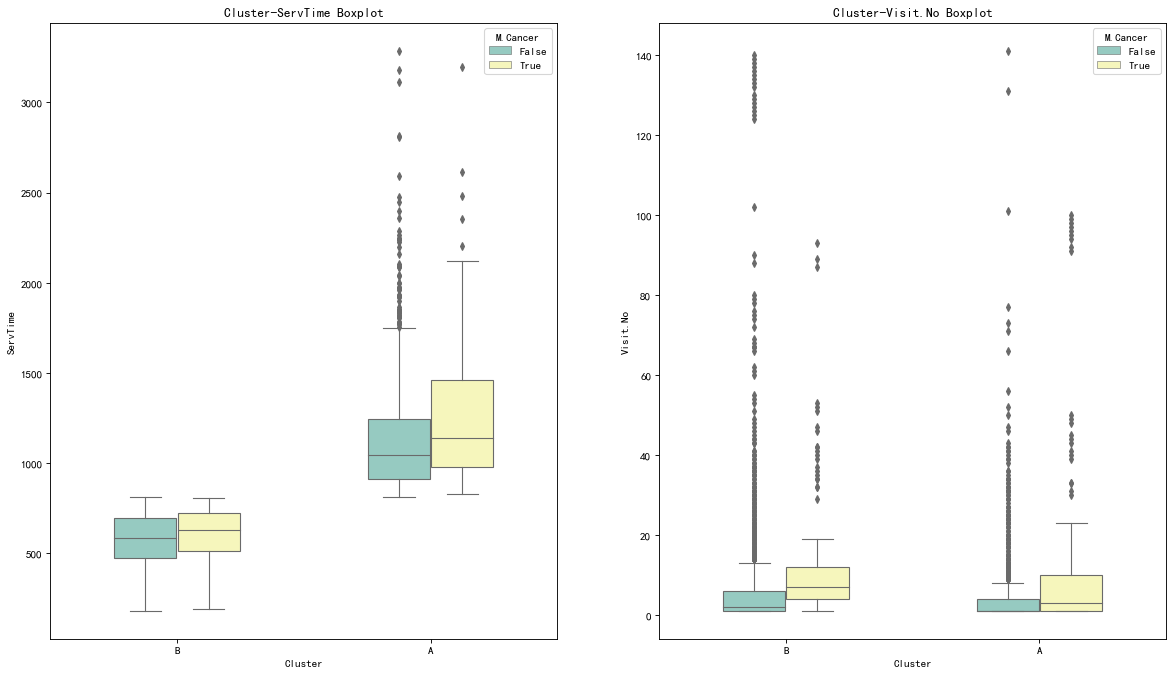

When k = 3


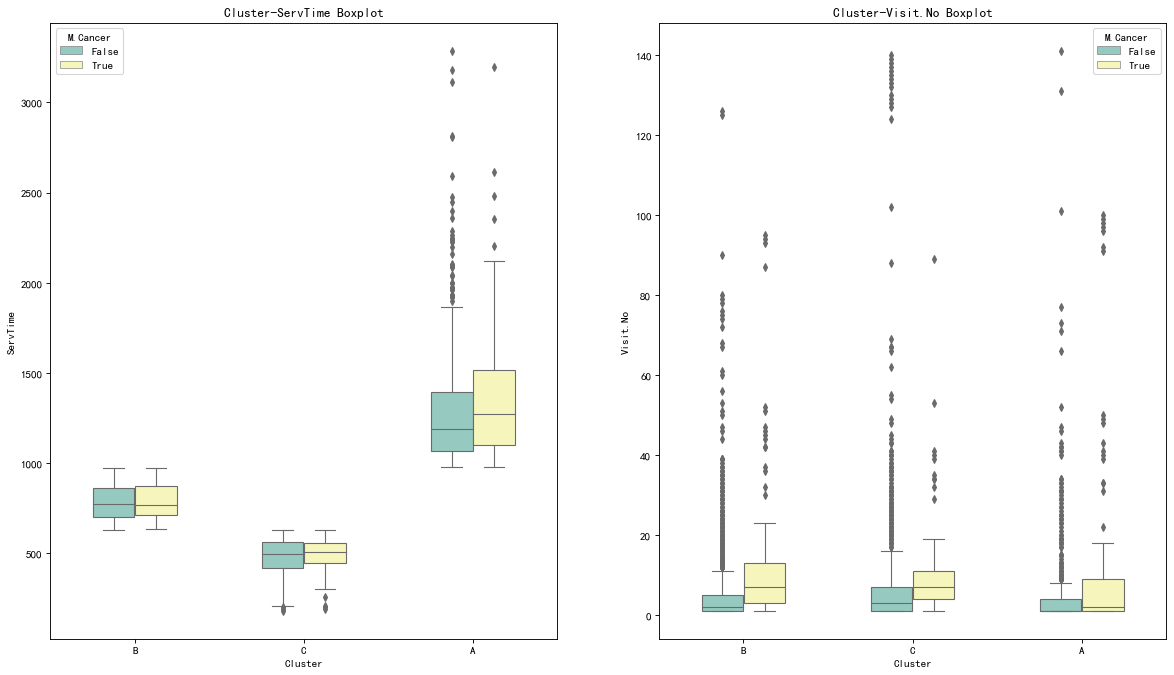

In [27]:
for k in [2,3]:
    
    print("When k =",k)
    df_pro_5 = XX[k].copy() #Obtain the sample data of the clusters generated by the currently considered most desirable clustering model
    if k==2:
        # View the composition of each category when divided into two categories
        #df_pro_5['Cluster'] = df_pro_5['Cluster'].map({1:'A',0:'B'}) # kmeans
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B'}) # kmedian
    elif k==3:
        # View the composition of each category when divided into three categories
        #df_pro_5['Cluster'] = df_pro_5['Cluster'].map({2:'A',1:'B',0:'C'}) # kmeans
        df_pro_5['Cluster'] = df_pro_5['Cluster'].map({0:'A',1:'B',2:'C'}) # kmedian
    else:
        print("Error in k value !")
        
    # Using box line plots to plot the relationship between different types of patients, different M. Cancer characteristics and service times
    fig, ax =plt.subplots(1,2,figsize=(18,10),dpi = 80)
    ax1=sns.boxplot(x ='Cluster', y ='ServTime', data =df_pro_5,ax=ax[0], hue ='M.Cancer', width=0.5, linewidth=1.0, palette="Set3"); 
    ax1.set_title("Cluster-ServTime Boxplot")
    # Plotting the relationship between different types of patients, different M.Cancer characteristics and Visit.No using box-line plots
    ax2=sns.boxplot(x ='Cluster', y ='Visit.No', data =df_pro_5,ax=ax[1], hue ='M.Cancer', width=0.5, linewidth=1.0, palette="Set3");
    ax2.set_title("Cluster-Visit.No Boxplot")
    plt.show()
    

### Showing classification rules (decision trees)

In [28]:
# Generate classification rules in the form of decision trees

__author__ = "Mayur Kulkarni <mayur.kulkarni@xoriant.com>"

def train_model(patient,target,depth,Seed):
    """
    Train decision tree classifier
 
    :param patient:    patient data set instance
    :return:        classifier instance
    """
    
    clf = tree.DecisionTreeClassifier(max_depth=depth,random_state=Seed)
    clf = clf.fit(patient,target)
    return clf
  
def display_image(clf, patient,target_names,k):
    """
    Displays the decision tree image
 
    :param clf:     classifier instance
    :param patient:    patient data set instance
    :param target_names:
    """
    KK=['K2','K3']
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=patient.columns.to_list(),
                                    class_names=target_names,
                                    filled=False, rounded=True)
    
    dot_data = dot_data.replace('\n','') # clean the black block
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    display(Image(data=graph.create_png()))
    graph.write_pdf('./figures/kmedians_decision_tree_'+KK[k-2]+'.pdf')

When k =  2


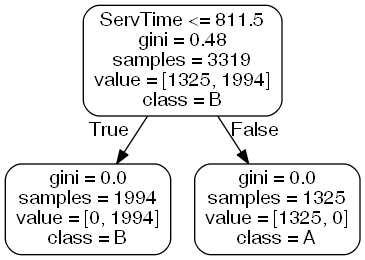

When k =  3


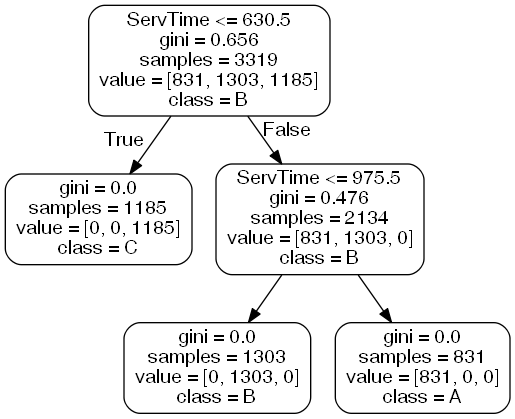

In [29]:
# Consider only ServTime
if Tree_Flag==True:
    
    patient5 = df_pro_5[['ServTime']].copy() 
    #patient5 = df_pro_5[['pred_xgb']].copy() # use predicted service time in training data set
    DecisionTree_Classifier_List=[np.nan for i in range(5)]
    depth=3 

    for k in [2,3]:
        if k==2:
            ClassList=['A', 'B']
        else:
            ClassList=['A', 'B', 'C']
        print("When k = ",k)
        best_kproto_5 = models_5[K_5.index(k)]
        target_5 = best_kproto_5.labels_
        target_names_5= np.array(ClassList[0:k], dtype='<U10')  #kMedians
        #target_names_5 = np.array(['B', 'A'], dtype='<U10') #kMeans
        # Training classifier models
        DecisionTree_Classifier_List[k] = train_model(patient5,target_5,depth,Seed)
        # Drawing decision trees
        display_image(DecisionTree_Classifier_List[k],patient5,target_names_5,k)
          

## Follow-up SIMULATION analysis

In [30]:
# Read prediction data
df_p1 = pd.read_csv("../Generated Data/0806model2.csv")# Read prediction data
print(df_p1.shape)
df_merge=df_p1.copy()
#df_merge['Initial'] = df_merge['Visit.No'].map(lambda x: False if x>=2 else True) # Get the categorical variable Initial from Visit.No
df_merge['Initial'] = df_merge['if_return'].map(lambda x: True if x==False else False) # Get the categorical variable Initial from if_return
#df_merge['Initial'] = df_merge['if_return2'].map(lambda x: True if x==False else False) # Get the categorical variable Initial from if_return2

print(df_merge.shape)
df_merge.head()

(3318, 23)
(3318, 24)


,Unnamed: 0,Unnamed: 0.1,ID,Session,Month,DayOfWeek,WorkingDay,AM_PM,Visit.No,Gender,...,Address,ServTime,if_return,duration_history2,duration_history2b,class1,class2,y_true,xgb_model2_55,Initial
0,3319,3425,H17D2EFE92,195,January,Wednesday,True,afternoon,11.0,M,...,In the city,965,True,677.555556,677.555556,1,1,965,655.04830,False
1,3320,3426,H08861D896,195,January,Wednesday,True,afternoon,2.0,F,...,In the city,867,True,653.875000,653.875000,1,1,867,738.92110,False
2,3321,3427,H24797A761,195,January,Wednesday,True,afternoon,6.0,F,...,Out of city,1525,True,1022.000000,1022.000000,2,1,1525,866.76587,False
3,3322,3428,H70AECCF93,195,January,Wednesday,True,afternoon,1.0,M,...,NaN,1729,False,915.798253,737.427184,2,1,1729,868.28253,True
4,3323,3429,H06938AC1F,195,January,Wednesday,True,afternoon,5.0,F,...,NaN,788,True,954.333333,954.333333,1,0,788,779.62490,False


In [31]:
print(df_merge.columns)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'ID', 'Session', 'Month', 'DayOfWeek',
       'WorkingDay', 'AM_PM', 'Visit.No', 'Gender', 'M.Cancer', 'S.Cancer',
       'StartTime', 'PayTime', 'Address', 'ServTime', 'if_return',
       'duration_history2', 'duration_history2b', 'class1', 'class2', 'y_true',
       'xgb_model2_55', 'Initial'],
      dtype='object')


In [32]:
df_merge.drop(columns = ['Unnamed: 0','ID','Session','Month','DayOfWeek','WorkingDay','AM_PM','S.Cancer','StartTime','PayTime','if_return','duration_history2','y_true'],inplace = True)
#df_merge.rename(columns={'ServTime': 'RealServTime','xgb_model5_70': 'ServTime'},inplace=True)
df_merge.rename(columns={'ServTime': 'RealServTime','xgb_model2_55': 'ServTime'},inplace=True)
# View data overview and missing values
total_nan_values = df_merge[['Visit.No','RealServTime','ServTime','M.Cancer']].isnull().sum().sum()
print ("The number of missing values is",total_nan_values)
df_p=df_merge.copy()
df_p.info()
if total_nan_values>0:
    df_p.dropna(subset=['Visit.No','RealServTime','ServTime','M.Cancer'],inplace=True)#Delete records with missing values
    df_p.reset_index(drop=True)#Rebuilding indexes to maintain index continuity


The number of missing values is 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318 entries, 0 to 3317
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0.1        3318 non-null   int64  
 1   Visit.No            3318 non-null   float64
 2   Gender              3318 non-null   object 
 3   M.Cancer            3318 non-null   bool   
 4   Address             2214 non-null   object 
 5   RealServTime        3318 non-null   int64  
 6   duration_history2b  3318 non-null   float64
 7   class1              3318 non-null   int64  
 8   class2              3318 non-null   int64  
 9   ServTime            3318 non-null   float64
 10  Initial             3318 non-null   bool   
dtypes: bool(2), float64(3), int64(4), object(2)
memory usage: 239.9+ KB


In [33]:
df_p.head()

,Unnamed: 0.1,Visit.No,Gender,M.Cancer,Address,RealServTime,duration_history2b,class1,class2,ServTime,Initial
0,3425,11.0,M,False,In the city,965,677.555556,1,1,655.04830,False
1,3426,2.0,F,False,In the city,867,653.875000,1,1,738.92110,False
2,3427,6.0,F,False,Out of city,1525,1022.000000,2,1,866.76587,False
3,3428,1.0,M,False,NaN,1729,737.427184,2,1,868.28253,True
4,3429,5.0,F,False,NaN,788,954.333333,1,0,779.62490,False


In [34]:
def Class_CutPoints(ServTime,k,CutPoints_List=CutPoints_List):  # CutPoints
    if k==2:
        
        if ServTime >= CutPoints_List[k][0]:
            Class_tag = "A"
        else:
            Class_tag = "B"
            
    elif k==3:
        
        if ServTime >= CutPoints_List[k][1]:
            Class_tag = "A"
        elif ServTime >= CutPoints_List[k][0]:
            Class_tag = "B" 
        else:
            Class_tag = "C"
            
    else:
        print("The value of k must be 2 or 3")
        
    return Class_tag

In [35]:
# Used for test for Class_CutPoints
def Class_MedianTest(sample,Medians):  # Medians_Test
    distance = [abs(x - sample['ServTime']) for x in Medians]
    distance_index=distance.index(min(distance))
    if distance_index == 0:
        Class_tag = "A"
    elif distance_index == 1:
        Class_tag = "B"
    else:
        Class_tag = "C"
    return Class_tag

In [36]:
def Class_IniCa(sample):  #Functions used to calculate the primary diagnosis-cancer classification method
    Initial_tag, Cancer_tag = sample['Initial'],sample['M.Cancer']
    if (Initial_tag==True) & (Cancer_tag==True):
        Class_tag = "A"
    elif (Initial_tag==True) & (Cancer_tag==False):
        Class_tag = "B"
    else:
        Class_tag = "C"
    return Class_tag

In [37]:
df_p['NR_MC']=df_p.apply(Class_IniCa,axis=1) #According to the first diagnosis of cancer, the first diagnosis of non-cancer, non-first diagnosis is divided into three categories A,B,C 
df_p['New_Return']=df_p['Initial'].map({True:'New',False:'Return'})

#df_p['DayOfWeek']=df_p['DayOfWeek'].map({'Friday':5,'Saturday':6,'Tuesday':2,'Wednesday':3})
df_p_temp = copy.copy(df_p) #Only real service hours are considered

In [38]:
# Determine the category of patients
ClusterName_List=["K2","K3"]
ii=0
for k in [2,3]:
    if Tree_Flag==True:
        #df_p['CPS_real_'+ClusterName_List[ii]]=DecisionTree_Classifier_List[k].predict(df_p_temp[["RealServTime"]])#Only real service hours are considered
        df_p['CPS_'+ClusterName_List[ii]]=DecisionTree_Classifier_List[k].predict(df_p_temp[["ServTime"]])#Consider only predicted service times
        
        if k == 2:
            #df_p['CPS_real_'+ClusterName_List[ii]]=df_p['CPS_real_'+ClusterName_List[ii]].map({0:'A',1:'B'}) #KMeadians
            df_p['CPS_'+ClusterName_List[ii]]=df_p['CPS_'+ClusterName_List[ii]].map({0:'A',1:'B'}) #KMeadians
        else:
            #df_p['CPS_real_'+ClusterName_List[ii]]=df_p['CPS_real_'+ClusterName_List[ii]].map({0:'A',1:'B',2:'C'}) #KMeadians
            df_p['CPS_'+ClusterName_List[ii]]=df_p['CPS_'+ClusterName_List[ii]].map({0:'A',1:'B',2:'C'}) #KMeadians
        
    else:
        df_p['CPS_real_'+ClusterName_List[ii]]=df_p_temp["RealServTime"].apply(Class_CutPoints,args=(k,))#Only real service hours are considered
        df_p['CPS_'+ClusterName_List[ii]]=df_p_temp["ServTime"].apply(Class_CutPoints,args=(k,))#Consider only predicted service times
        
    ii=ii+1
    

In [39]:
df_p

,Unnamed: 0.1,Visit.No,Gender,M.Cancer,Address,RealServTime,duration_history2b,class1,class2,ServTime,Initial,NR_MC,New_Return,CPS_K2,CPS_K3
0,3425,11.0,M,False,In the city,965,677.555556,1,1,655.04830,False,C,Return,B,B
1,3426,2.0,F,False,In the city,867,653.875000,1,1,738.92110,False,C,Return,B,B
2,3427,6.0,F,False,Out of city,1525,1022.000000,2,1,866.76587,False,C,Return,A,B
3,3428,1.0,M,False,NaN,1729,737.427184,2,1,868.28253,True,B,New,A,B
4,3429,5.0,F,False,NaN,788,954.333333,1,0,779.62490,False,C,Return,B,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3313,6848,10.0,F,False,In the city,206,599.666667,0,0,635.51510,False,C,Return,B,B
3314,6849,2.0,M,False,Out of province,684,769.500000,1,0,801.82210,False,C,Return,B,B
3315,6850,1.0,M,False,In the city,1191,736.727162,2,1,845.97217,True,B,New,A,B
3316,6851,36.0,F,False,In the city,459,905.888889,0,0,834.13650,False,C,Return,A,B


In [40]:
# Show the data 
df_Simu_pred=df_p.copy()
print(df_Simu_pred.columns.tolist())
df_Simu_pred.head()

['Unnamed: 0.1', 'Visit.No', 'Gender', 'M.Cancer', 'Address', 'RealServTime', 'duration_history2b', 'class1', 'class2', 'ServTime', 'Initial', 'NR_MC', 'New_Return', 'CPS_K2', 'CPS_K3']


,Unnamed: 0.1,Visit.No,Gender,M.Cancer,Address,RealServTime,duration_history2b,class1,class2,ServTime,Initial,NR_MC,New_Return,CPS_K2,CPS_K3
0,3425,11.0,M,False,In the city,965,677.555556,1,1,655.04830,False,C,Return,B,B
1,3426,2.0,F,False,In the city,867,653.875000,1,1,738.92110,False,C,Return,B,B
2,3427,6.0,F,False,Out of city,1525,1022.000000,2,1,866.76587,False,C,Return,A,B
3,3428,1.0,M,False,NaN,1729,737.427184,2,1,868.28253,True,B,New,A,B
4,3429,5.0,F,False,NaN,788,954.333333,1,0,779.62490,False,C,Return,B,B


In [41]:
ClassNameList = ['CPS_K2','CPS_K3','New_Return','NR_MC']
ClusterMean(df_Simu_pred,ClassNameList,ServTime_flag='ServTime')

A    1665
B    1653
Name: CPS_K2, dtype: int64
mean ServTime of A is 15.298846025325336 min
percent of A is 0.5018083182640145
num_to_16 of A is 8.028933092224232
----------
mean ServTime of B is 11.519846715970987 min
percent of B is 0.49819168173598555
num_to_16 of B is 7.971066907775769
----------
----------
A     193
B    2698
C     427
Name: CPS_K3, dtype: int64
mean ServTime of A is 20.056567829879093 min
percent of A is 0.058167570825798674
num_to_16 of A is 0.9306811332127788
----------
mean ServTime of B is 13.53716311273784 min
percent of B is 0.8131404460518384
num_to_16 of B is 13.010247136829415
----------
mean ServTime of C is 9.650354998438704 min
percent of C is 0.12869198312236288
num_to_16 of C is 2.059071729957806
----------
----------
New       1247
Return    2071
Name: New_Return, dtype: int64
mean ServTime of New is 15.469509306067831 min
percent of New is 0.3758288125376733
num_to_16 of New is 6.013261000602773
----------
mean ServTime of Return is 12.17981996571

In [42]:
ClusterVar(df_Simu_pred,ClassNameList,ServTime_flag='ServTime')

A    1665
B    1653
Name: CPS_K2, dtype: int64
variance ServTime in mins of A is 4.38647807888996 
variance ServTime in mins of B is 1.9734379526747603 
The variances is [4.38647807888996, 1.9734379526747603]
----------
A     193
B    2698
C     427
Name: CPS_K3, dtype: int64
variance ServTime in mins of A is 9.290514676154423 
variance ServTime in mins of B is 2.097867017336603 
variance ServTime in mins of C is 0.8404693535285478 
The variances is [9.290514676154423, 2.097867017336603, 0.8404693535285478]
----------
New       1247
Return    2071
Name: New_Return, dtype: int64
variance ServTime in mins of New is 5.418565518897519 
variance ServTime in mins of Return is 3.4928646226319358 
The variances is [5.418565518897519, 3.4928646226319358]
----------
A      91
B    1156
C    2071
Name: NR_MC, dtype: int64
variance ServTime in mins of A is 1.80388365601601 
variance ServTime in mins of B is 0.7830143272639328 
variance ServTime in mins of C is 3.4928646226319358 
The variances is 

In [43]:
ClusterCV(df_Simu_pred,ClassNameList,ServTime_flag='ServTime')

A    1665
B    1653
Name: CPS_K2, dtype: int64
cv ServTime in mins of A is 0.13689869492488138 
cv ServTime in mins of B is 0.12194529193511161 
The cv is [0.13689869492488138, 0.12194529193511161]
----------
A     193
B    2698
C     427
Name: CPS_K3, dtype: int64
cv ServTime in mins of A is 0.15197189197046515 
cv ServTime in mins of B is 0.10699446602270853 
cv ServTime in mins of C is 0.09499869763585841 
The cv is [0.15197189197046515, 0.10699446602270853, 0.09499869763585841]
----------
New       1247
Return    2071
Name: New_Return, dtype: int64
cv ServTime in mins of New is 0.15047544157510567 
cv ServTime in mins of Return is 0.15344403413952232 
The cv is [0.15047544157510567, 0.15344403413952232]
----------
A      91
B    1156
C    2071
Name: NR_MC, dtype: int64
cv ServTime in mins of A is 0.05819401918567192 
cv ServTime in mins of B is 0.05950597805494988 
cv ServTime in mins of C is 0.15344403413952232 
The cv is [0.05819401918567192, 0.05950597805494988, 0.15344403413952

In [44]:
df_Simu_pred['New_Return']=df_Simu_pred['Initial'].map({True:'A',False:'B'}) #New/Return patient is noted as type A/B

In [45]:
df_Simu_pred.head()

,Unnamed: 0.1,Visit.No,Gender,M.Cancer,Address,RealServTime,duration_history2b,class1,class2,ServTime,Initial,NR_MC,New_Return,CPS_K2,CPS_K3
0,3425,11.0,M,False,In the city,965,677.555556,1,1,655.04830,False,C,B,B,B
1,3426,2.0,F,False,In the city,867,653.875000,1,1,738.92110,False,C,B,B,B
2,3427,6.0,F,False,Out of city,1525,1022.000000,2,1,866.76587,False,C,B,A,B
3,3428,1.0,M,False,NaN,1729,737.427184,2,1,868.28253,True,B,A,A,B
4,3429,5.0,F,False,NaN,788,954.333333,1,0,779.62490,False,C,B,B,B


In [46]:
print("Tree_Flag is",Tree_Flag)

Tree_Flag is True


In [48]:
if Tree_Flag==True:
    df_Simu_pred.to_csv("../Generated Data/HANGU_ServiceTime_Simu_Cluster_Tree_Classification_K2K3_model2_55_230806_240307.csv",index=False)
else:
    df_Simu_pred.to_csv("../Generated Data/HANGU_ServiceTime_Simu_Cluster_CutoffPoints_Classification_K2K3_230214.csv",index=False)

**End**